# Reanalyzing dataset from Neftel, Laffy, et al. 2019 - Part 2

I will be using the file from the end of [Part 1](./Part1_FindingMalignantCells.ipynb), `neftel_smartseq2_malignant.h5ad`. This file contains only the malignant cells from the SMART-Seq2 data.

We will be exploring the malignant cell data and the meta-modules defined by Neftel et al., which they used to categorize the cell by subtype and identify hybrid cells belonging to multiple subtypes.

## Exploring malignant cell data

We begin with importing packages and setting up the figure settings, as well as reading in the data.

Note: There may be unused imports below, which should be removed when finished.

In [1]:
import numpy as np
import pandas as pd
import math

import scanpy as sc
import decoupler

import matplotlib.pyplot as plt

In [2]:
sc.set_figure_params(dpi=150, figsize=(3, 3), frameon=False)

In [3]:
adata = sc.read("neftel_smartseq2_malignant.h5ad")

## Exploring pathway analysis

I will be following along with Chapter 18 of the Single Cell Best Practices online book, looking at gene set enrichment and pathway analysis.

Since I have relative expression data, and there is no real "condition" to investigate for differential gene expression, I will be using AUCell to look at the meta-module gene sets identified by the authors. These are the gene sets associated with the cell states MES-like, AC-like, NPC-like, and OPC-like, as well as two meta-modules to identify cycling cells.

In [4]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

C:\Users\Andrew\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


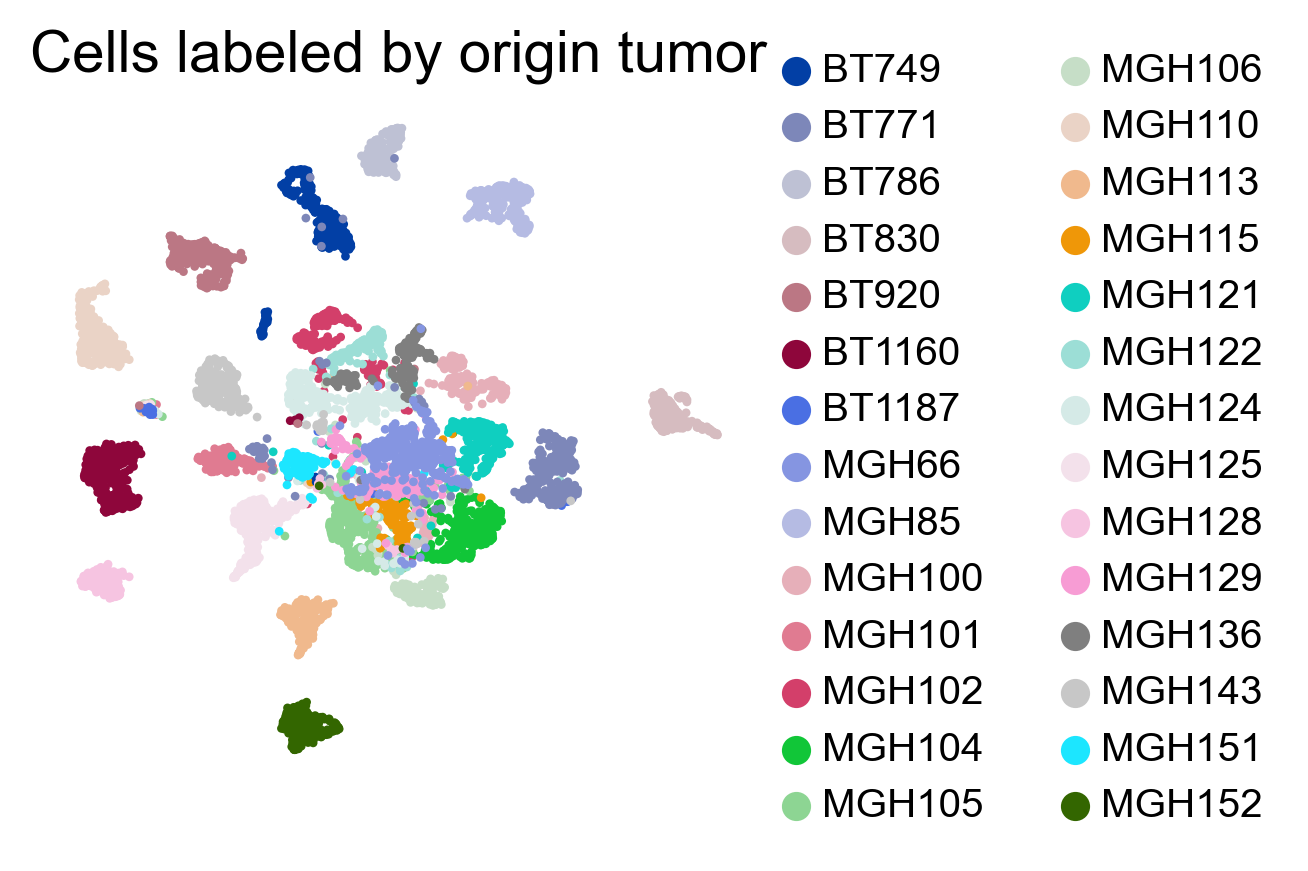

In [5]:
sc.pl.umap(
    adata,
    color=["origin"],
    frameon=False,
    title="Cells labeled by origin tumor",
    legend_fontsize="x-small",
    
)

In [6]:
# We will explore the "meta-modules" that were defined by Neftel et al.
# these comprise 8 sets of genes: 6 for the hetereogeneous subtypes of cells identified, and 2 for cell cycling status

genesets = pd.read_csv("metamodule_genesets.csv")
genesets

genesymbol geneset
0       HILPDA    MES2
1          ADM    MES2
2        DDIT3    MES2
3        NDRG1    MES2
4      HERPUD1    MES2
..         ...     ...
358      GPSM2    G2/M
359      HMGB3    G2/M
360  ARHGAP11A    G2/M
361    RANGAP1    G2/M
362      H2AFZ    G2/M

[363 rows x 2 columns]

In [7]:
%%time
decoupler.run_aucell(
    adata,
    genesets,
    source="geneset",
    target="genesymbol",
    use_raw=False,
)

CPU times: total: 1min 39s
Wall time: 19.4 s


In [8]:
adata

AnnData object with n_obs × n_vars = 6860 × 23686
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'origin', 'celltype', 'avg_Macrophage', 'avg_T cell', 'avg_Oligodendrocyte'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'celltype_colors', 'neighbors', 'origin_colors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'aucell_estimate'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

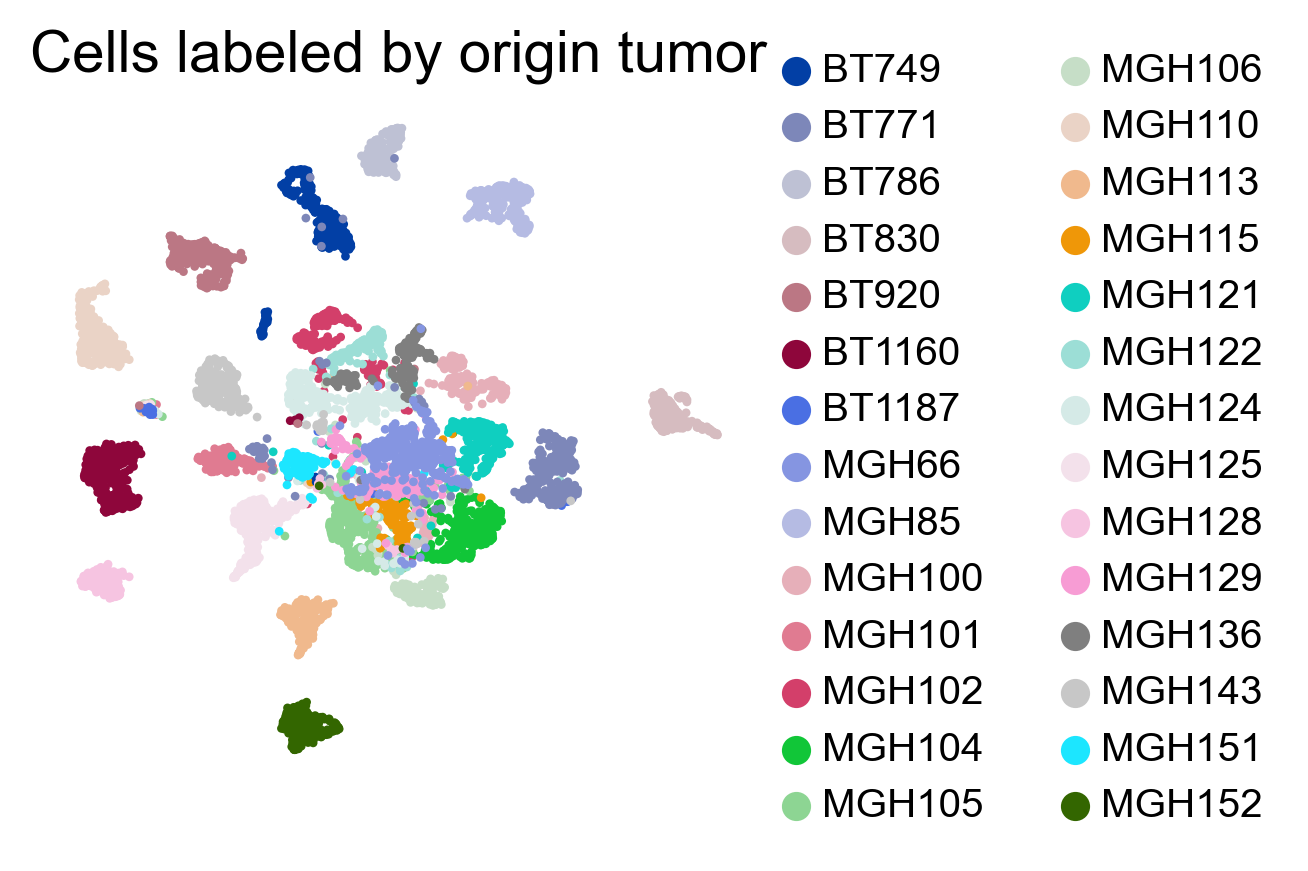

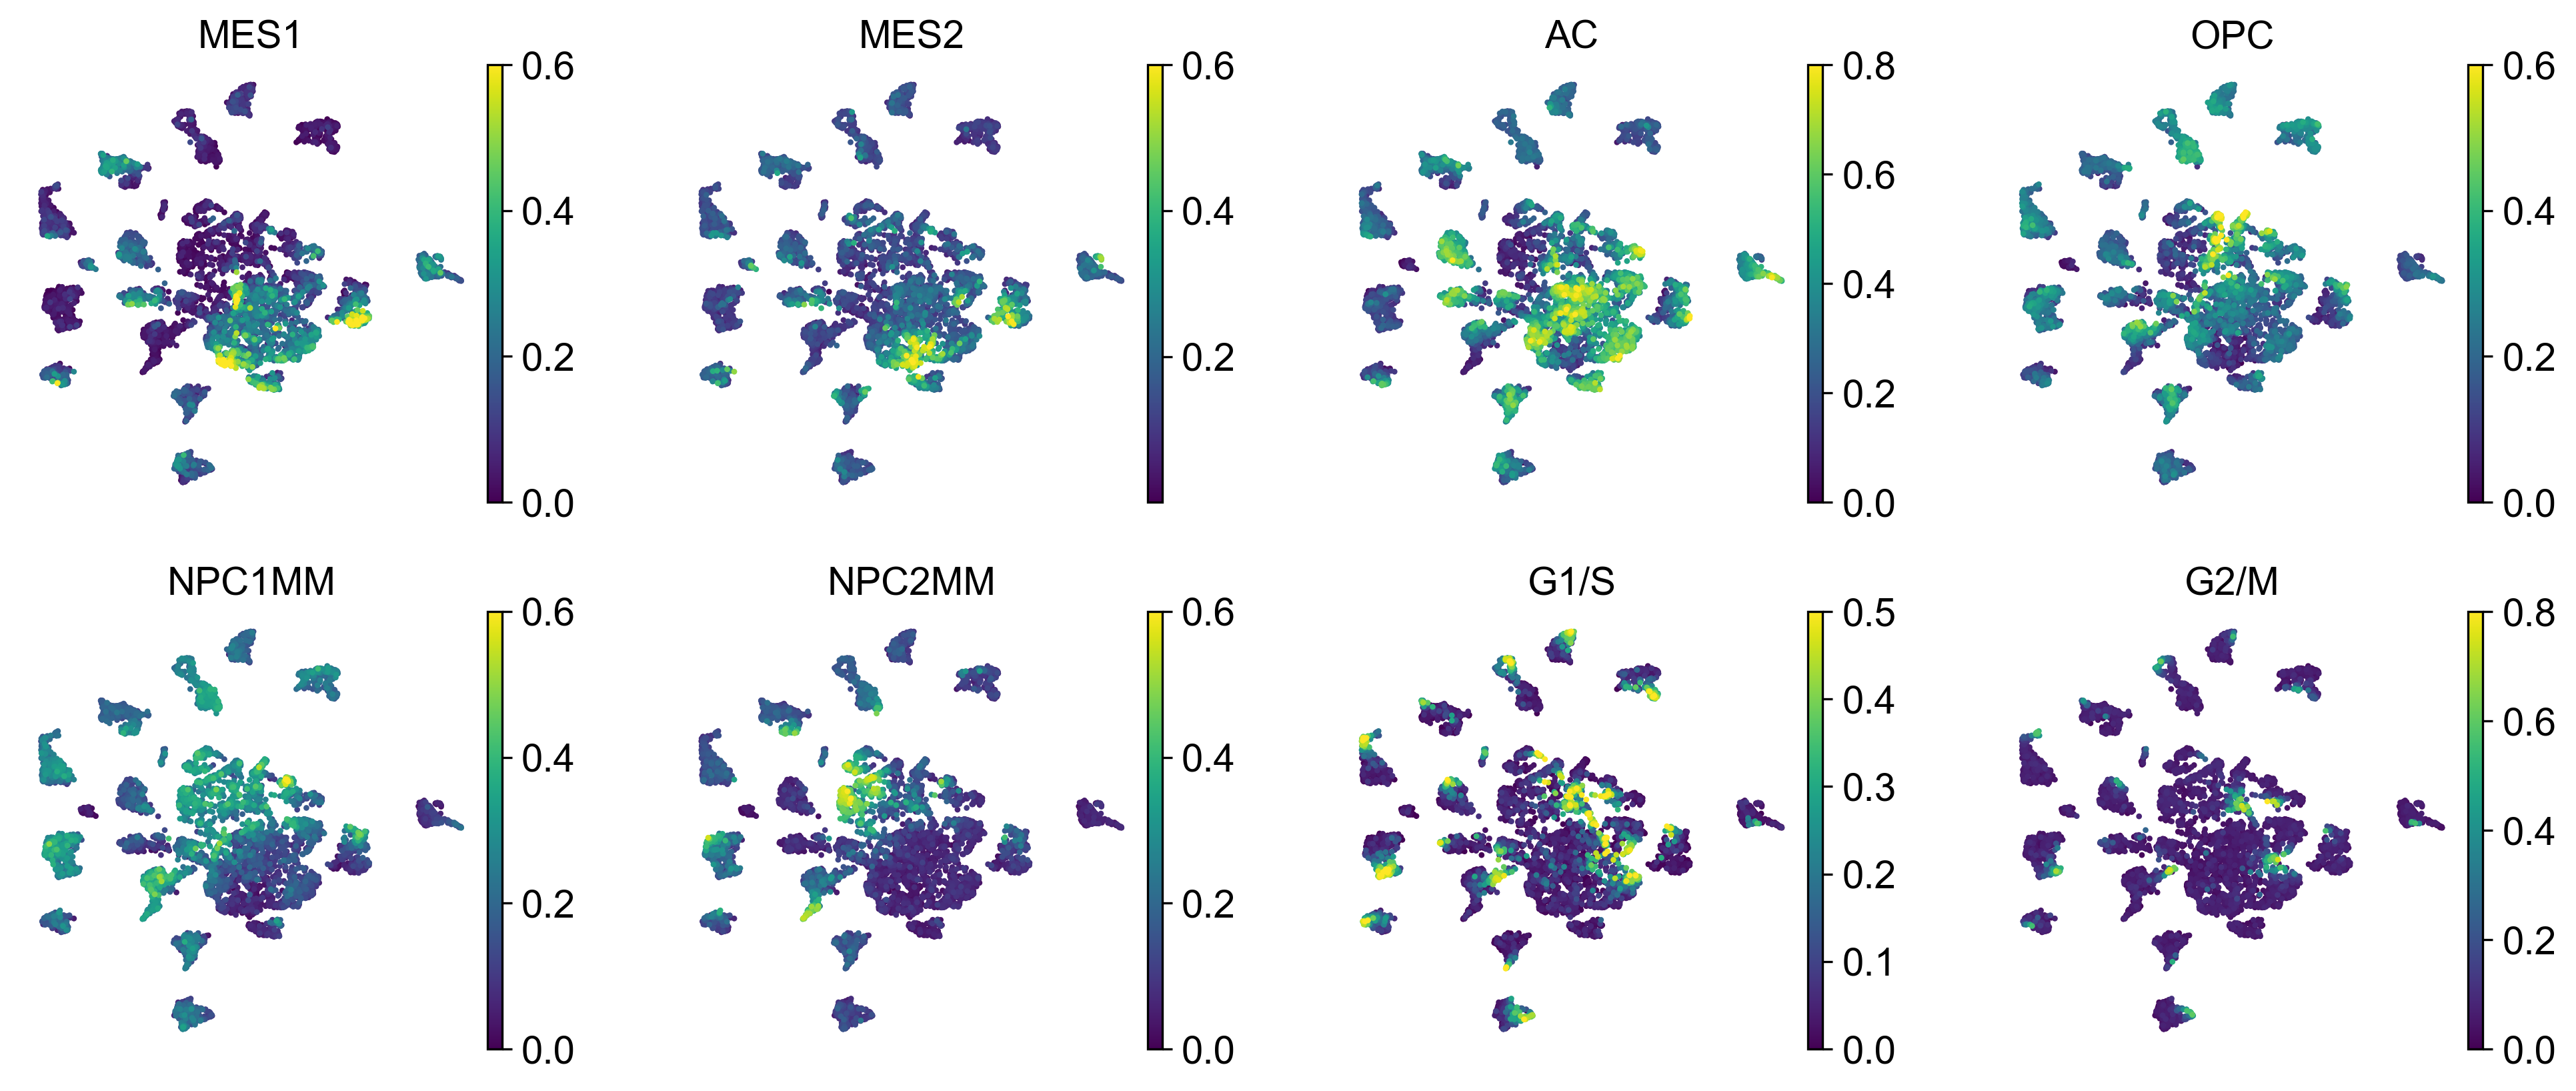

In [9]:
# We will visualize each of the identified meta-modules, using a constant vmax to allow for
# comparable plots when plotting cells from individual tumors.

metamodules = ["MES1","MES2","AC","OPC","NPC1MM","NPC2MM","G1/S","G2/M"]
mm_vmax = [0.6,0.6,0.8,0.6,0.6,0.6,0.5,0.8]

adata.obs[metamodules] = adata.obsm["aucell_estimate"][metamodules]

adata.write("neftel_smartseq2_malignant_with_mm.h5ad")

sc.pl.umap(
    adata,
    color=["origin"],
    frameon=False,
    title="Cells labeled by origin tumor",
    legend_fontsize="x-small",
)

sc.pl.umap(
    adata,
    color=metamodules,
    frameon=False,
    ncols=4,
    wspace=0.3,
    vmax=mm_vmax,
)

We can now compare the expression of each gene set to the identified cellular states in the different tumors.

The highlighted cell states from Figure 4, for example, show that MGH102 and MGH125 both contain mostly NPC-like and OPC-like cells. We should thus be able to limit the plot to just the cells from MGH102 and MGH125 and see elevated expression of the NPC1, NPC2, and OPC metamodules within those cells.

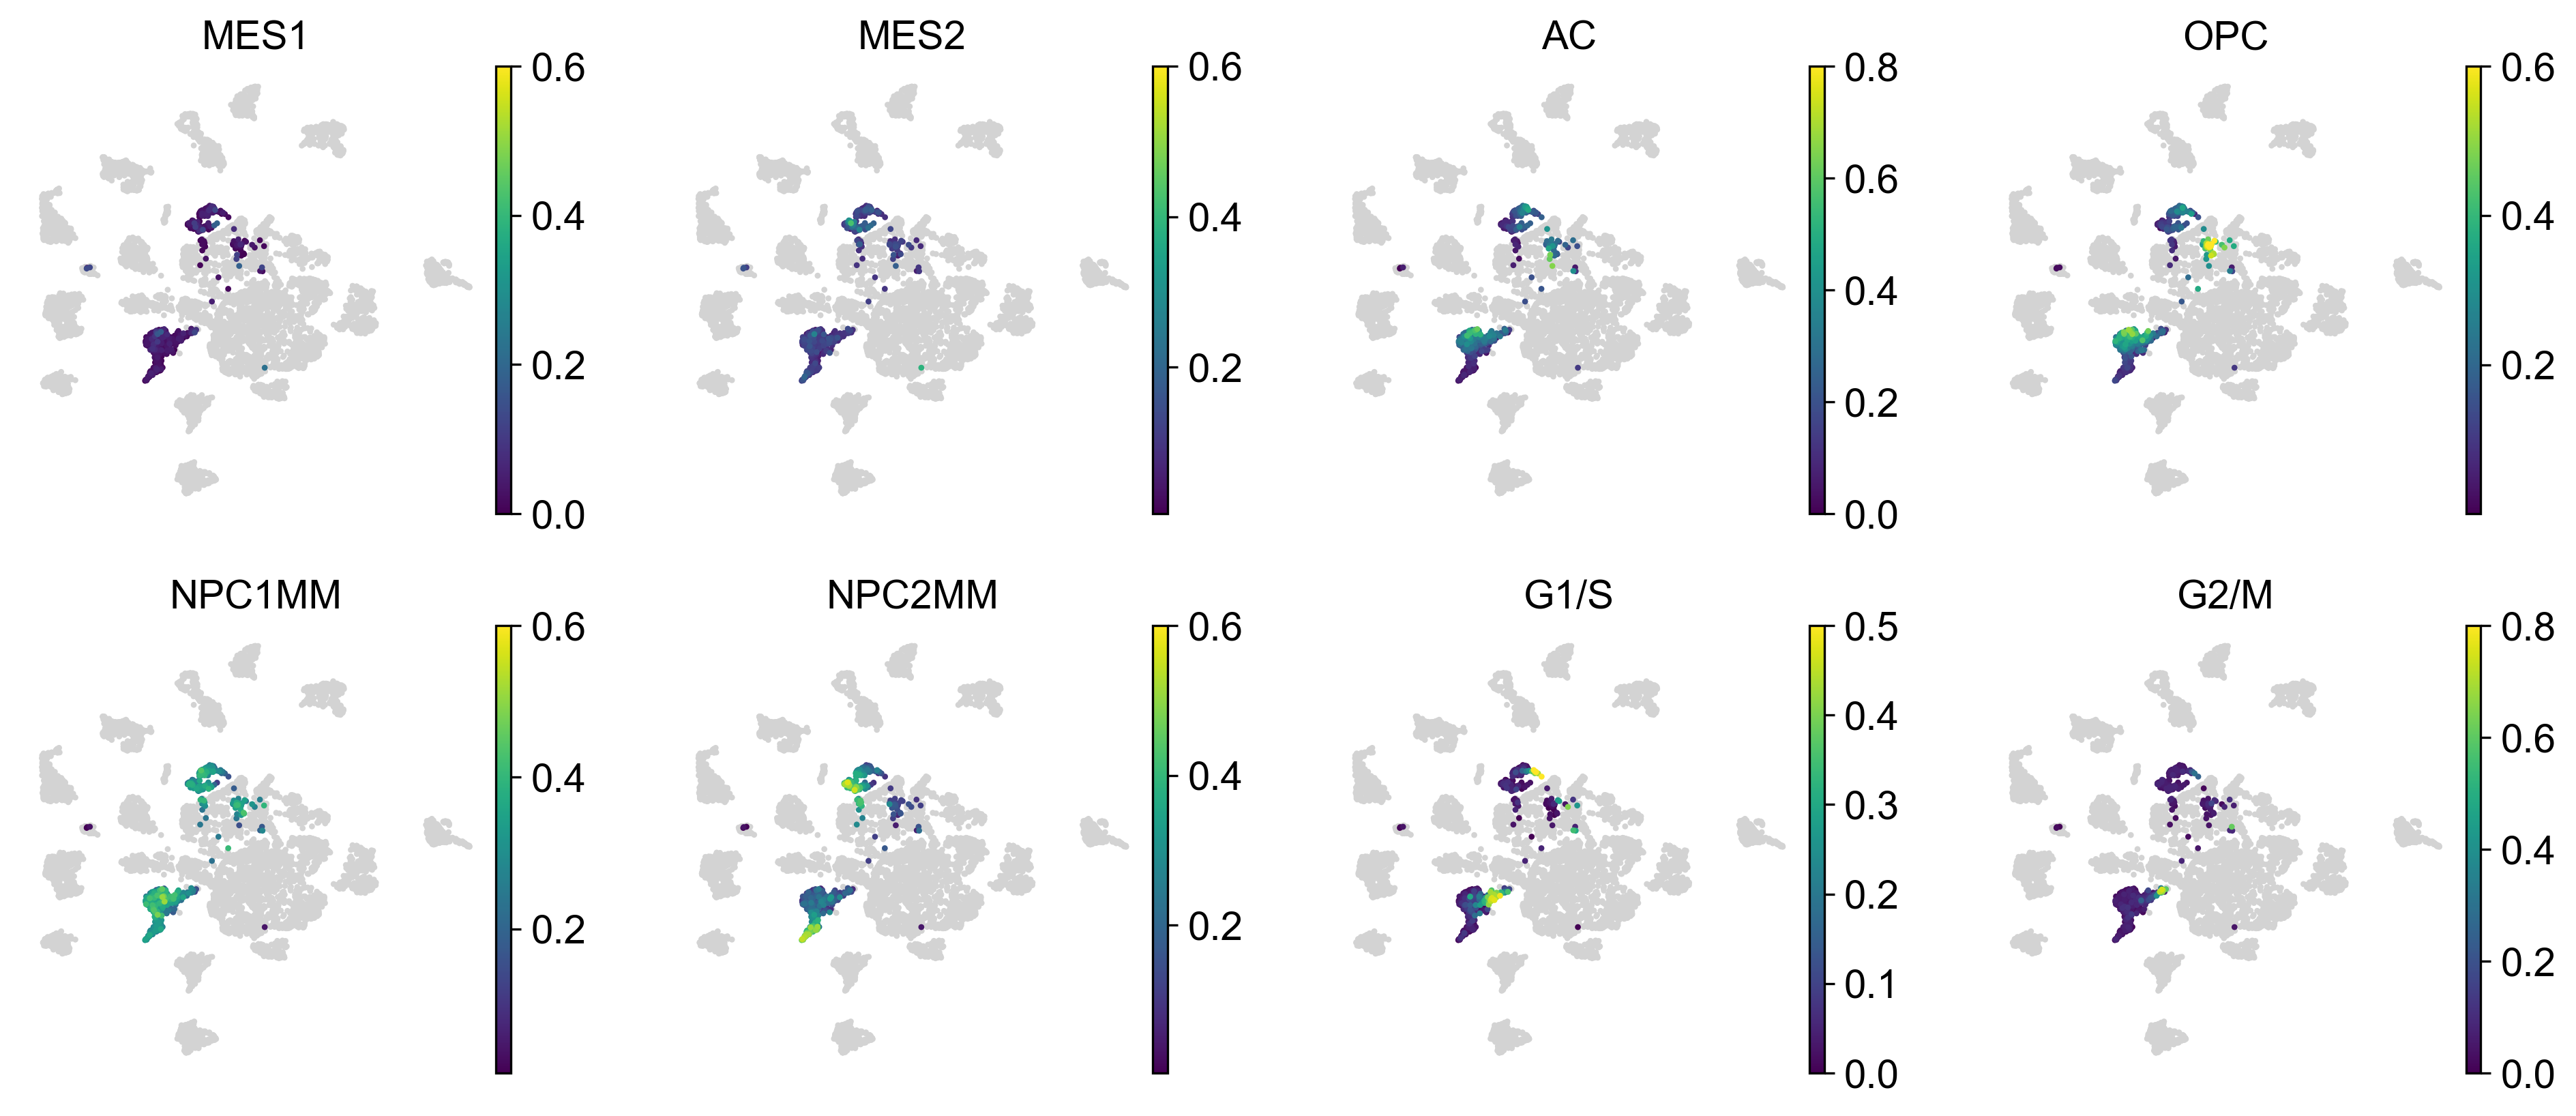

In [10]:
# NOTE: Due to a bug with the way mask_obs works, I am using a temporary copy of the data
#   whenever I am plotting with a mask.
# Otherwise, the mask "sticks" and continues to affect downstream umap plots.
bdata = adata.copy()
sc.pl.umap(
    bdata,
    color=metamodules,
    frameon=False,
    ncols=4,
    mask_obs=(adata.obs.origin.isin(["MGH102","MGH125"])),
    vmax=mm_vmax
)
del bdata

By contrast, we can look at a tumor that contained mostly MES-like and AC-like cells, MGH105.

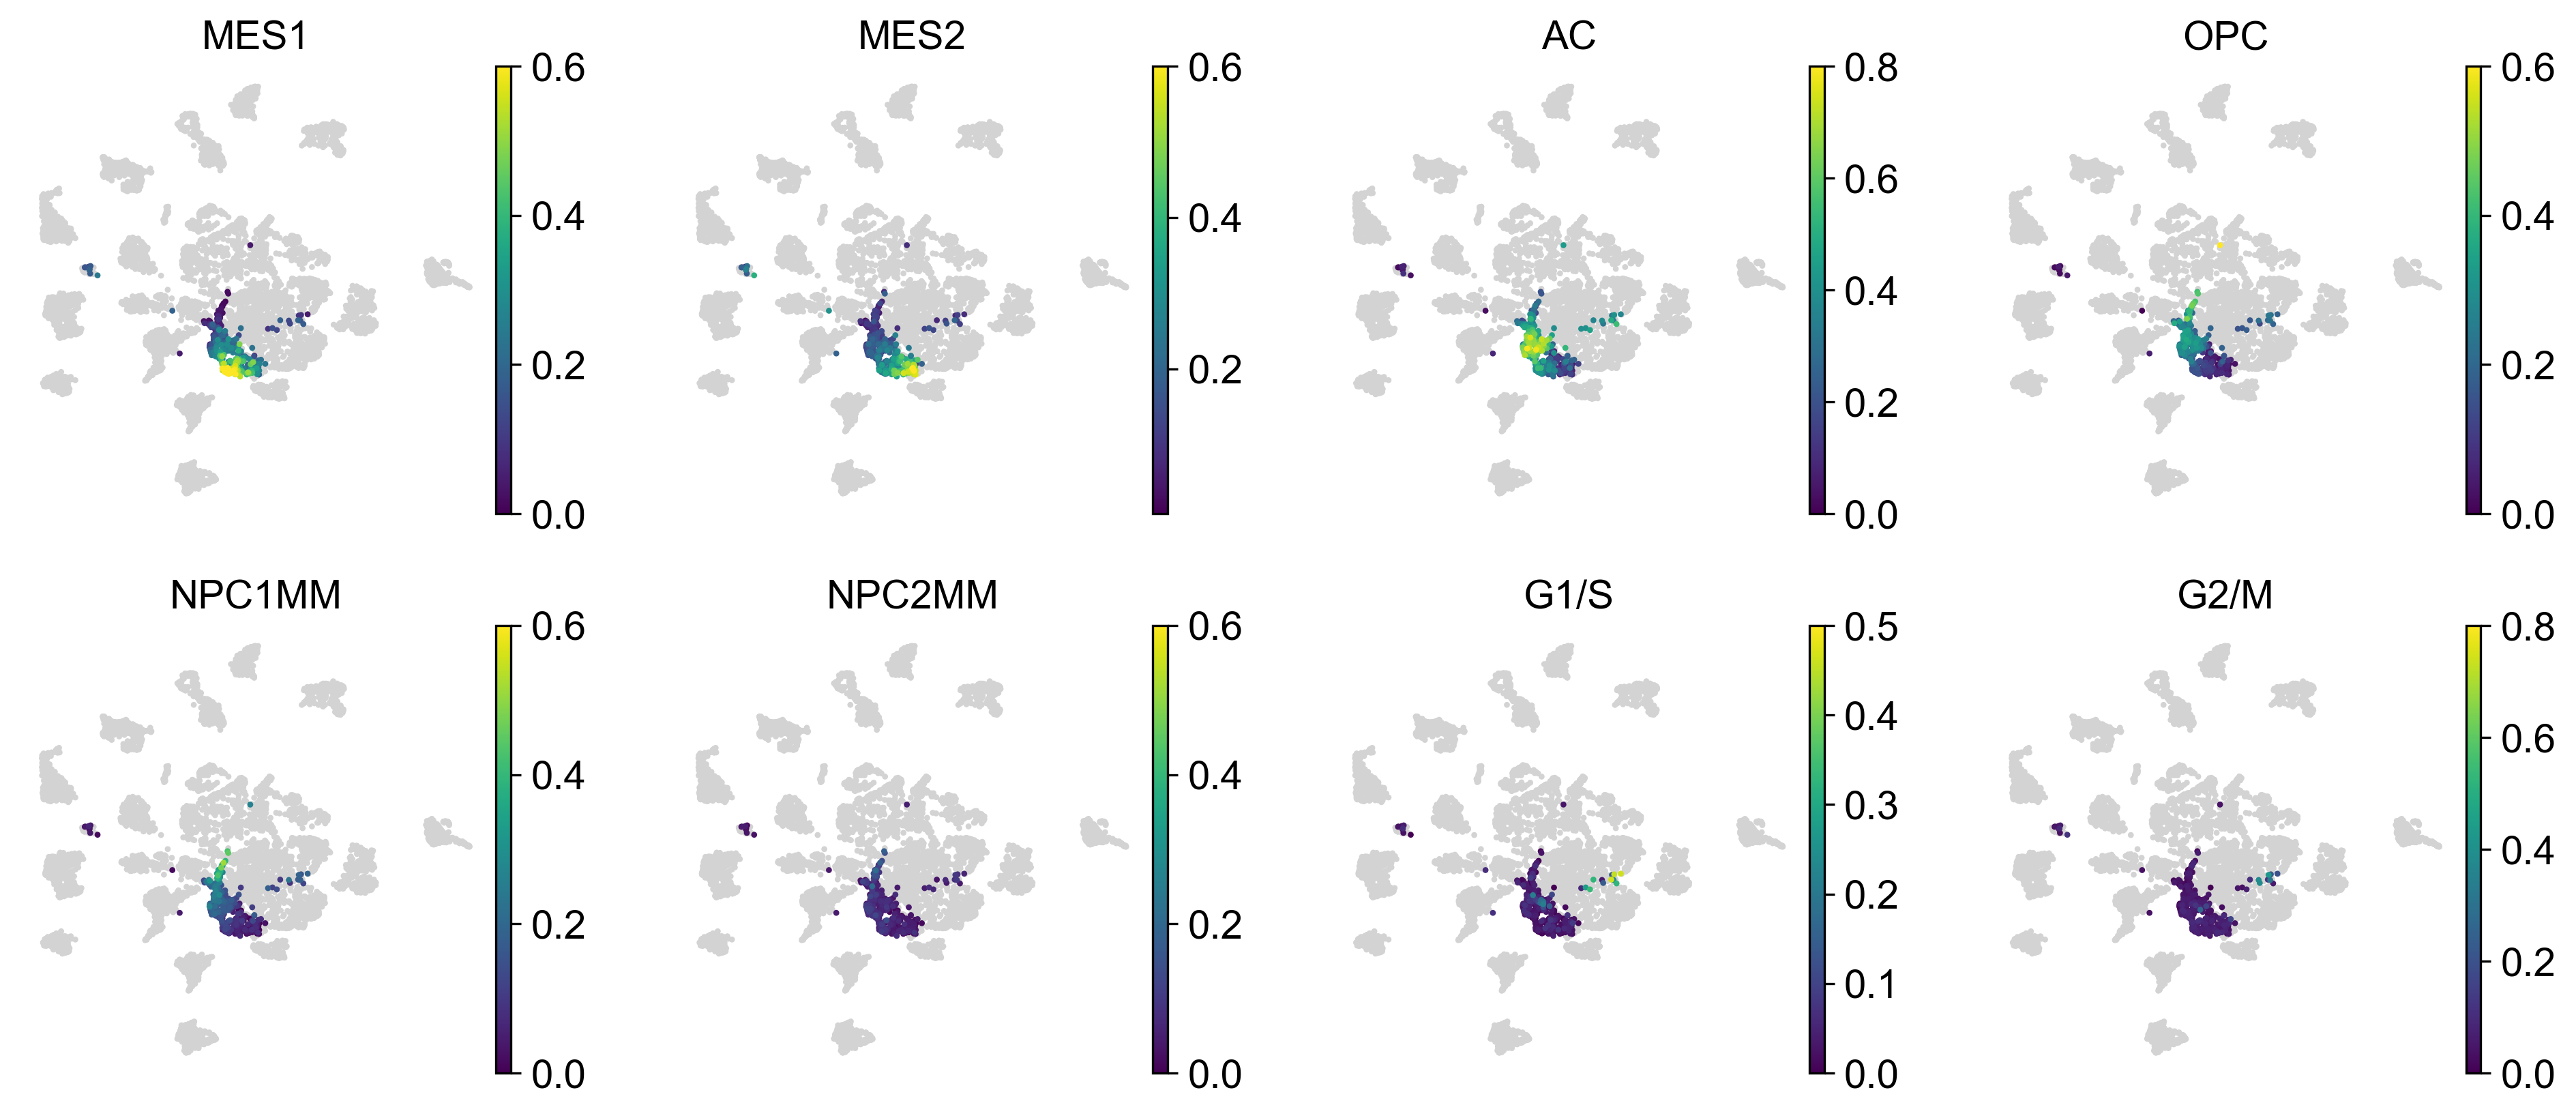

In [11]:
bdata = adata.copy()
sc.pl.umap(
    bdata,
    color=metamodules,
    frameon=False,
    ncols=4,
    mask_obs=adata.obs.origin.isin(["MGH105"]),
    vmax=mm_vmax
)
del bdata

Thus we are able to verify that the subtypes identified by Neftel et al. follow the expression patterns based on the meta-modules. Next we will assign cells to meta-modules and identify hybrid cells.

### Assigning cells to meta-modules and identifying hybrid cells

Following along with the "Assignment of cells to meta-modules and their hybrids" section of the paper, we will assign cells to one of the four groups: MES-like cells, NPC-like cells, AC-like cells, and OPC-like cells. We will also perform the hybrid definition step, and store this with our data so we can visualize this later.

The first thing to note is that my expression scores are different from those of the paper. The paper made scores using log2-ratios of average expression, whereas the AUCell estimates I am using are only comparable amongst themselves, with no "real" meaning. So it is difficult to apply the same criteria to identify hybridized cells, which rely on absolute limits to identify hybridized cells.

So we will modify the scoring criteria used slightly. With the knowledge that the original paper identified 15% of cells (~1030 cells) as hybrids, we can begin with some sensible values and then adjust them. The second criteria can be implemented exactly. The modified scoring criteria are as follows:

1. Criterion 1, "the score for the second meta-module was higher than 1", could not be used. Instead, I used the 20th percentile value of first meta-module scores to define an initial cut-off of 0.2718, which was raised to 0.29 when found to be too permissive.
2. Criterion 2, "the score for the second meta-module was higher than that of 10% of the cells that map to this meta-module (as their top-scoring meta-module)", was able to be implemented using my score data.
3. Criterion 3, "the difference in score between the second meta-module and the third meta-module was at least 0.3", could not be used. Instead, 0.05 was arbitrarily chosen as the cut-off.

In [12]:
subtypes = ["MES1","MES2","AC","OPC","NPC1MM","NPC2MM"]

# build dataframe containing subtype estimates from AUCell
st_est = pd.DataFrame(adata.obs["MES1"])

for x in range(1,len(subtypes)):
    st = subtypes[x]
    st_est[st] = adata.obs[st]

# make a getsubtype function to order and place subtype names and scores into a dataframe
def getsubtypes(cell):
    s = cell.sort_values(ascending=False)
    names = list(s.to_dict())
    values = s.to_list()
    # format: subtype1 = name, subtype2 = name, subtype3 = name
    # format: subtype1_val = score, etc.
    nd = {
        "subtype1":names[0],
        "subtype2":names[1],
        "subtype3":names[2],
        "subtype4":names[3],
        "subtype5":names[4],
        "subtype6":names[5],
        "subtype1_val":values[0],
        "subtype2_val":values[1],
        "subtype3_val":values[2],
        "subtype4_val":values[3],
        "subtype5_val":values[4],
        "subtype6_val":values[5],
    }
    return pd.Series(nd)

subtype_values = st_est.apply(getsubtypes, axis=1)

# for criterion 2, above, calculate the 10th percentile score for scores mapping to that meta-module as top
low_percentile = dict()
for st in subtypes:
    stval = subtype_values[subtype_values["subtype1"] == st].quantile(q=0.1, numeric_only=True)["subtype1_val"]
    low_percentile[st] = stval

# define the hybrid status based on the criteria above
def getsubtypehybridstatus(cell):
    # cell is a series containing subtype1, subtype1_val, etc.
    cutoff1 = 0.29
    cutoff2 = 0.05
    maintype = cell["subtype1"]
    st = cell["subtype2"]
    stval = cell["subtype2_val"]
    thirdmost = cell["subtype3_val"]
    if ((cell["subtype1"].startswith("MES") and 
         cell["subtype2"].startswith("MES")) or
         (cell["subtype1"].startswith("NPC") and 
         cell["subtype2"].startswith("NPC"))):
        st = cell["subtype3"]
        stval = cell["subtype3_val"]
        thirdmost=cell["subtype4_val"]
        if ((cell["subtype3"].startswith("MES") and 
         cell["subtype4"].startswith("MES")) or
         (cell["subtype3"].startswith("NPC") and 
         cell["subtype4"].startswith("NPC"))):
            thirdmost = cell["subtype5_val"]
        
    hybrid = False
    hybridtype = 'NA'

    if stval > low_percentile[st] and stval > cutoff1 and stval >= thirdmost + cutoff2:
        hybrid = True
        hybridtype = st

    combinedsubtype = maintype[:3]
    if hybrid:
        cs = [maintype[:3],hybridtype[:3]]
        cs.sort()
        combinedsubtype = "/".join(cs)

    d = {
        "main_subtype": maintype[:3],
        "hybrid": hybrid,
        "hybrid_subtype": hybridtype[:3],
        "combined_subtype": combinedsubtype,
    }
    return pd.Series(d)

hybrids = subtype_values.apply(getsubtypehybridstatus, axis=1)

# display hybrids
hybrids[hybrids["hybrid"]]

main_subtype  hybrid hybrid_subtype combined_subtype
MGH100-P5-B08          NPC    True            OPC          NPC/OPC
MGH100-P5-C10           AC    True            MES           AC/MES
MGH100-P5-D07           AC    True            OPC           AC/OPC
MGH100-P5-E02           AC    True            OPC           AC/OPC
MGH100-P5-E11          MES    True             AC           AC/MES
...                    ...     ...            ...              ...
MGH66-P08-D11           AC    True            OPC           AC/OPC
MGH66-P08-F11           AC    True            OPC           AC/OPC
MGH66-P08-G06           AC    True            MES           AC/MES
MGH66-P08-G07           AC    True            NPC           AC/NPC
MGH66-P08-G10           AC    True            MES           AC/MES

[1094 rows x 4 columns]

In [13]:
# transfer labels for main_subtype, hybrid status, and hybrid_subtype to adata

adata.obs["main_subtype"] = hybrids["main_subtype"]
adata.obs["hybrid"] = hybrids["hybrid"]
adata.obs["hybrid_subtype"] = hybrids["hybrid_subtype"]
adata.obs["combined_subtype"] = hybrids["combined_subtype"]

# define palettes for main_subtype and combined_subtype
#                     AC        AC/MES    AC/NPC     AC/OPC     MES     MES/NPC   NPC       NPC/OPC   OPC
combined_palette =["#D33333","#E3B333","#420032","#B333E3","#E3E333","#66FF66","#33A333","#33D3D3","#3333D3"]
#                  AC        MES       NPC       OPC
main_palette = ["#D33333","#E3E333","#33A333","#3333D3"]

The study states that 15% of cells were identified as hybrid cells, which is about 1029 identified cells. We identified 1094, which is rather close. It is difficult to assess whether we have identified the same cells, but at the very least we can visualize the cells by main subtype and combined hybrid subtype.

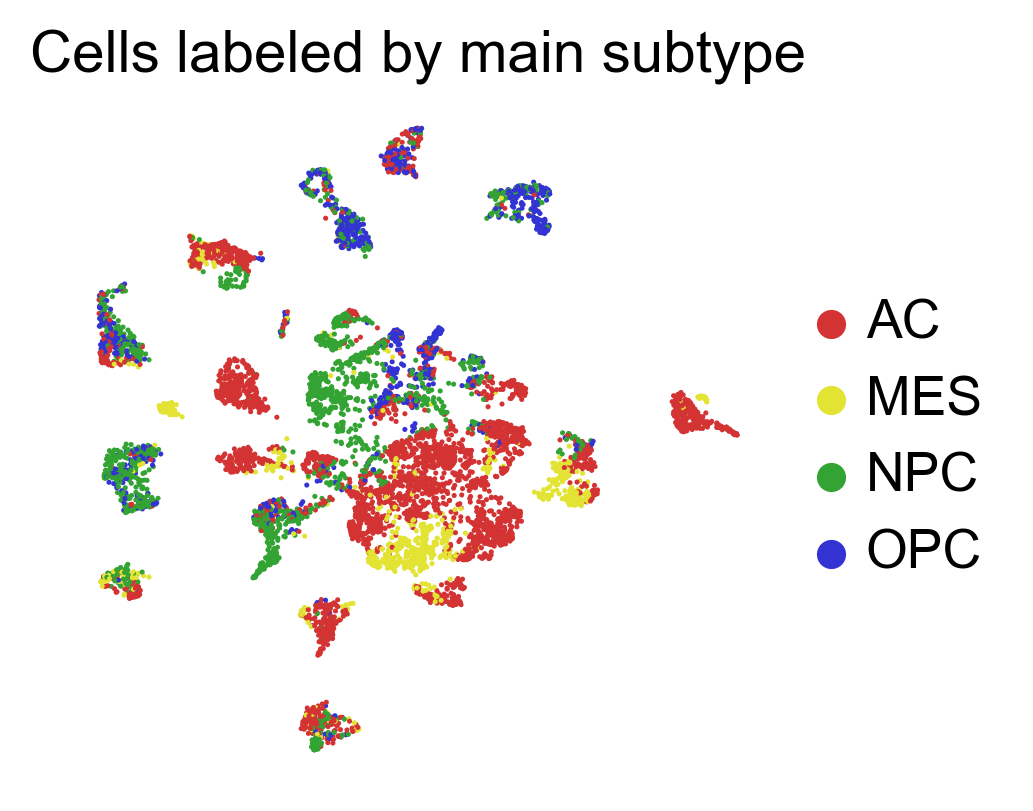

In [14]:
sc.pl.umap(
    adata,
    color=["main_subtype"],
    palette=main_palette,
    size=6,
    title="Cells labeled by main subtype",
)

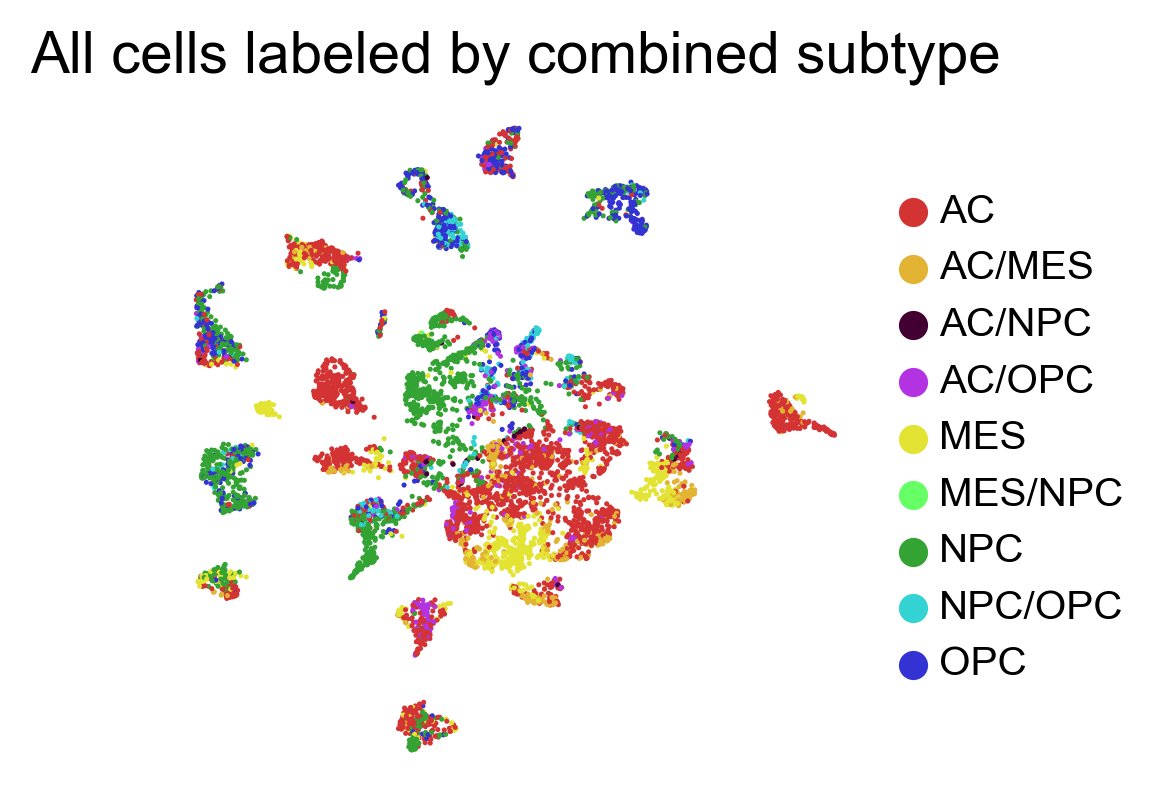

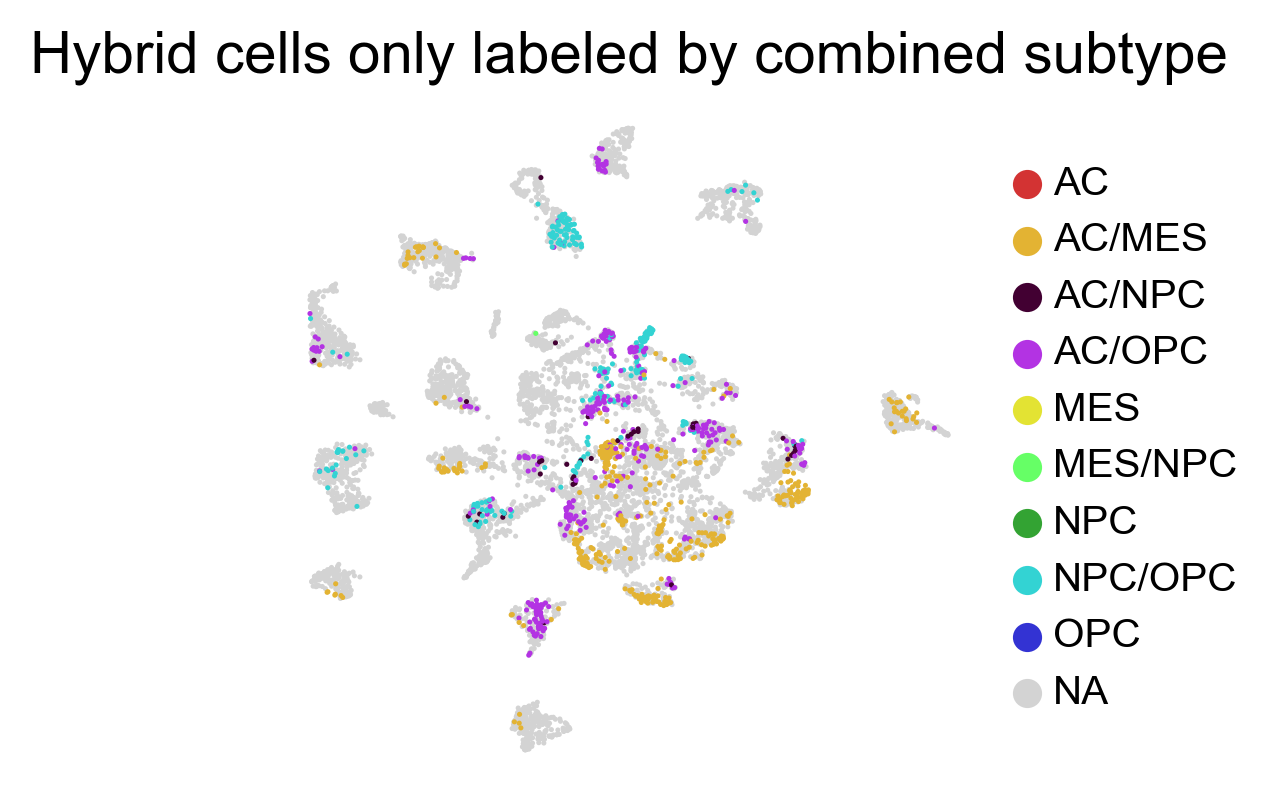

In [15]:
sc.pl.umap(
    adata,
    color=["combined_subtype"],
    palette=combined_palette,
    size=6,
    title="All cells labeled by combined subtype",
    legend_fontsize="x-small",
)

sc.pl.umap(
    adata.copy(),
    color=["combined_subtype"],
    mask_obs=adata.obs["hybrid"],
    palette=combined_palette,
    size=6,
    title="Hybrid cells only labeled by combined subtype",
    legend_fontsize="x-small",
)

## Verifying hybrid and main subtype assignments

First, we will examine the tumors we looked at above. Tumors MGH102 and MGH125 contained mostly NPC-like and OPC-like cells, whereas MGH105 contained mostly MES-like and AC-like cells.

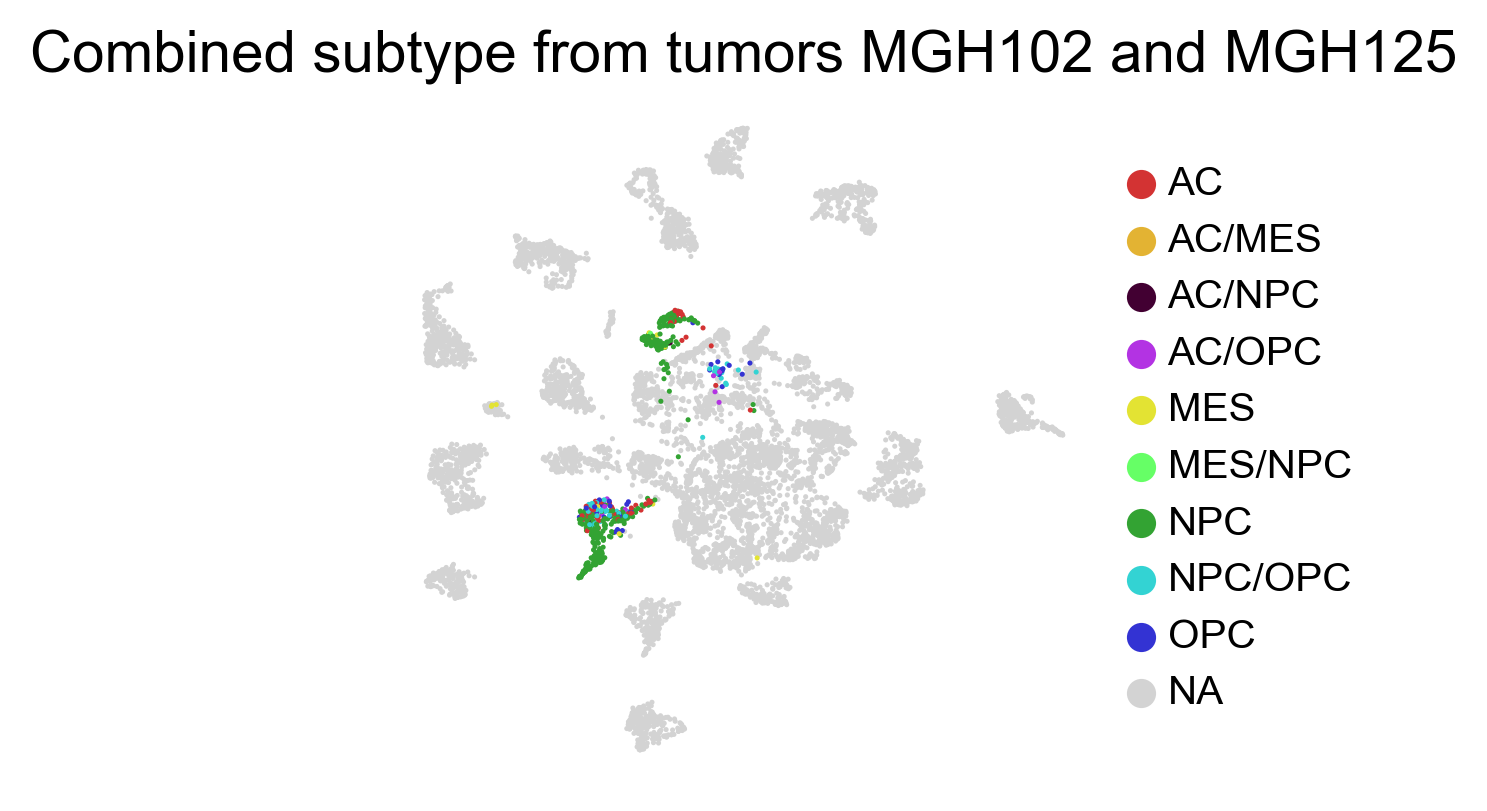

In [16]:
# 102 and 125 - NPC and OPC
sc.pl.umap(
    adata.copy(),
    color=["combined_subtype"],
    mask_obs=adata.obs.origin.isin(["MGH102", "MGH125"]),
    palette=combined_palette,
    size=6,
    title="Combined subtype from tumors MGH102 and MGH125",
    legend_fontsize="x-small",
)

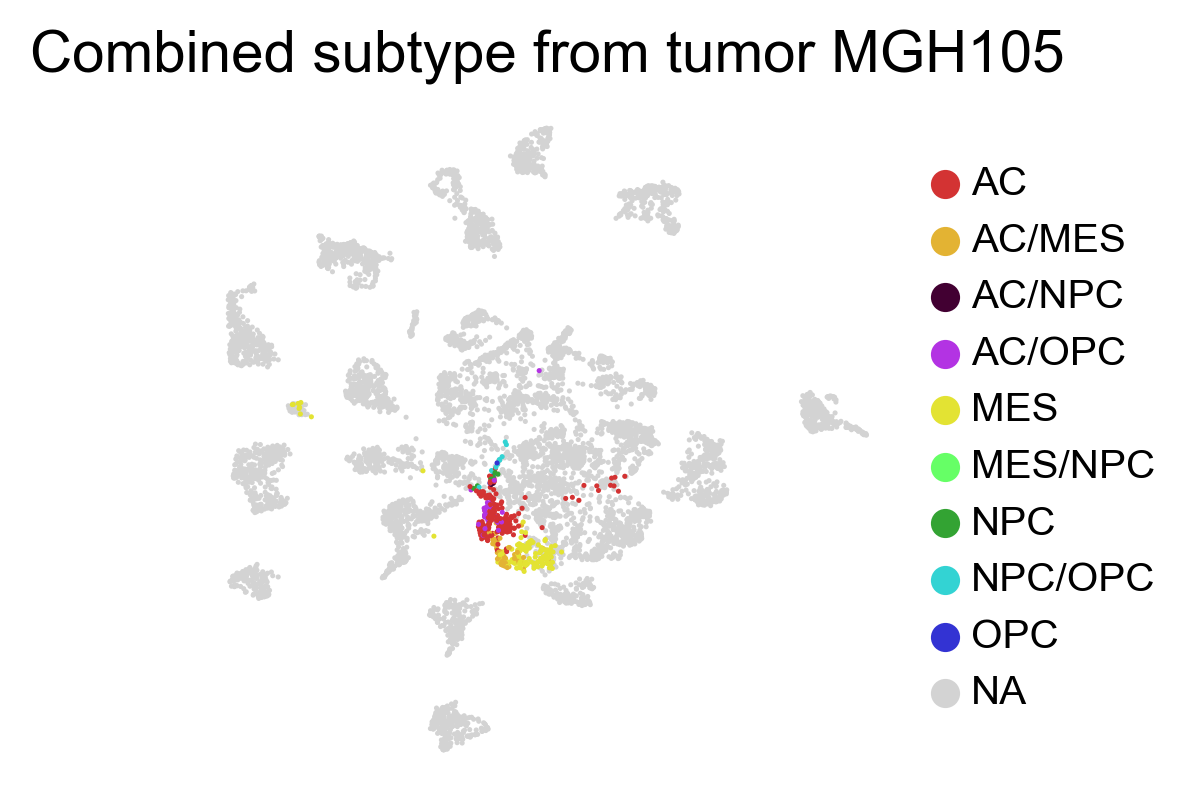

In [17]:
# 105 - MES and AC
sc.pl.umap(
    adata.copy(),
    color=["combined_subtype"],
    mask_obs=adata.obs.origin.isin(["MGH105"]),
    palette=combined_palette,
    size=6,
    title="Combined subtype from tumor MGH105",
    legend_fontsize="x-small",
)

Next, we will examine pediatric vs. adult tumors. The original paper found that adult cells contained mostly AC-like cells, whereas pediatric cells contained mostly OPC-like cells. The plots below show a similar trend.

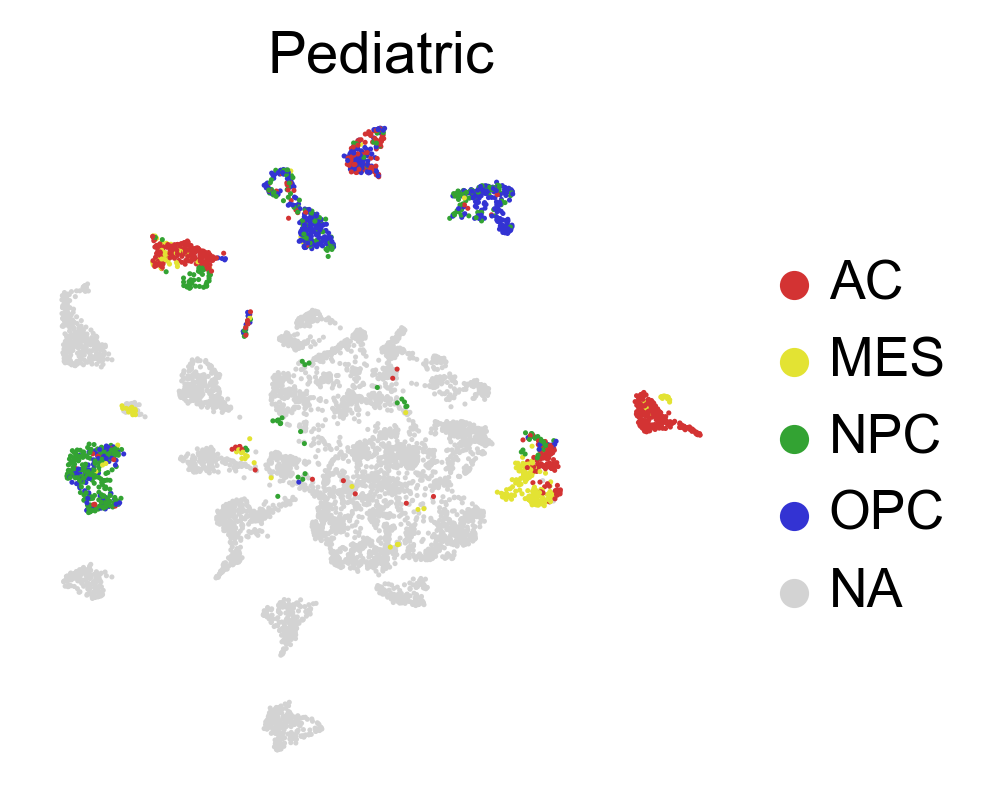

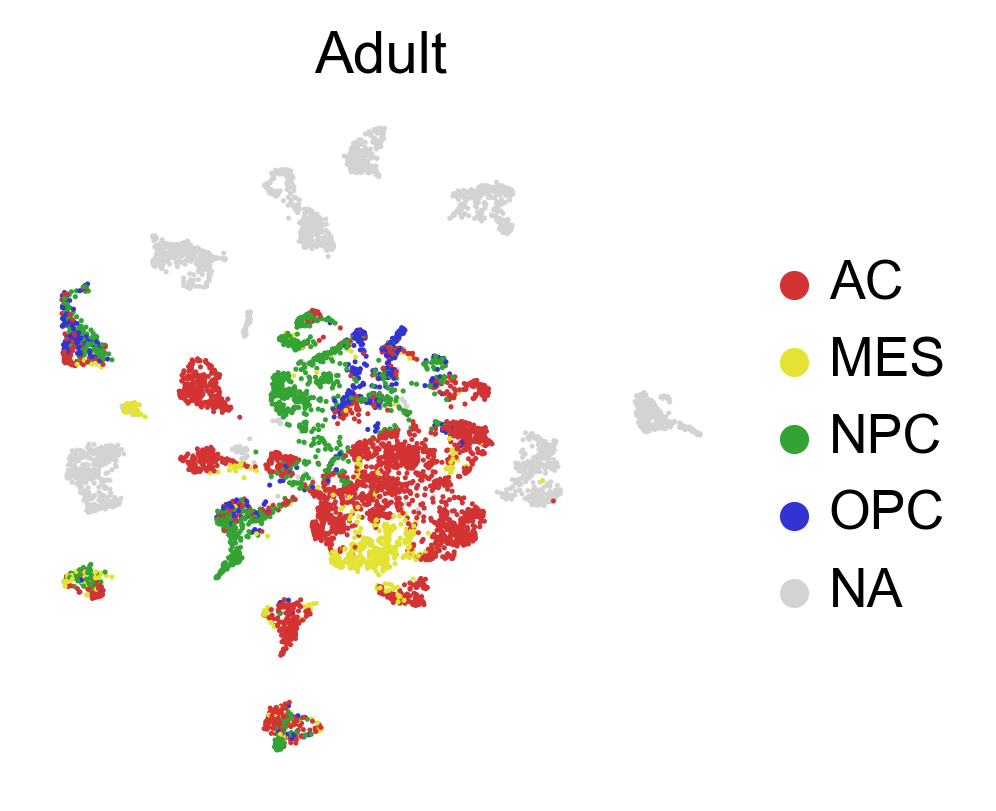

In [18]:
# assign pediatric vs. adult labels
adata.obs["origin_age"] = adata.obs["origin"].isin(["MGH85","BT749","BT771","BT786","BT830","BT920","BT1160","BT1187"]).replace({True:"Pediatric",False:"Adult"})

# Plotting only pediatric origin tumors
sc.pl.umap(
    adata.copy(),
    color=["main_subtype"],
    title="Pediatric",
    mask_obs=adata.obs.origin_age.isin(["Pediatric"]),
    palette=main_palette,
    size=6,
)

# Plotting only pediatric origin tumors
sc.pl.umap(
    adata.copy(),
    color=["main_subtype"],
    title="Adult",
    mask_obs=adata.obs.origin_age.isin(["Adult"]),
    palette=main_palette,
    size=6,
)

Finally, we can make something similar to the plot from Figure 3F, showing the hyrbid cells by relative meta-module score. The way they did scoring seems to have stretched the graph out a bit, as the "clusters" they saw are not evident here, but we can at least see the different subtypes and hybrids separating out by meta-module score properly.

Note that here, clockwise from the upper-right corner, the quadrants show NPC-like, MES-like, AC-like, and OPC-like cells.

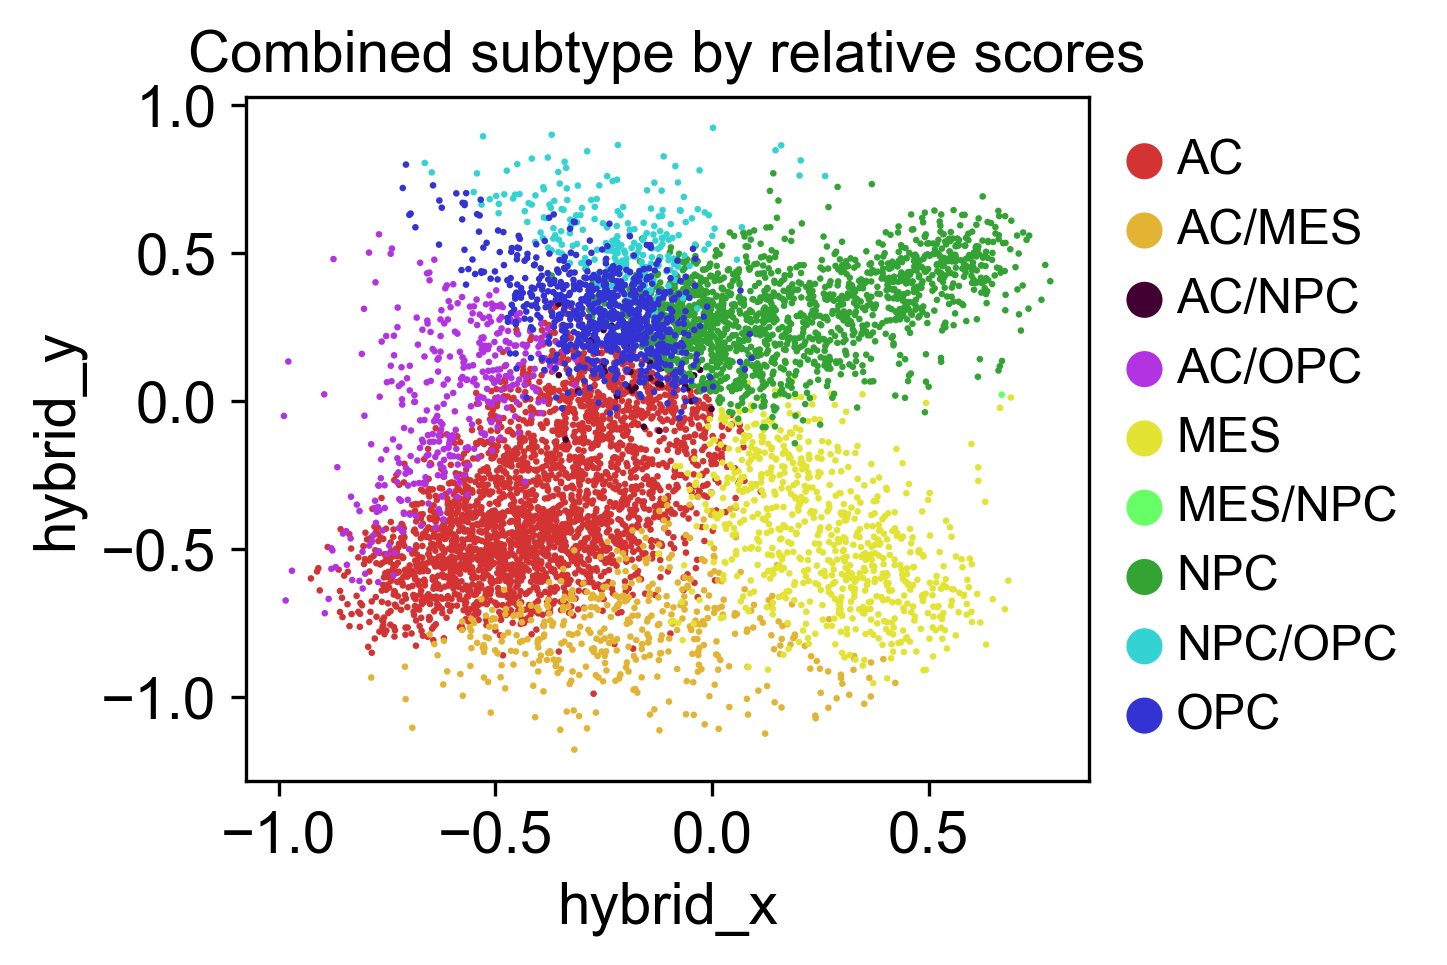

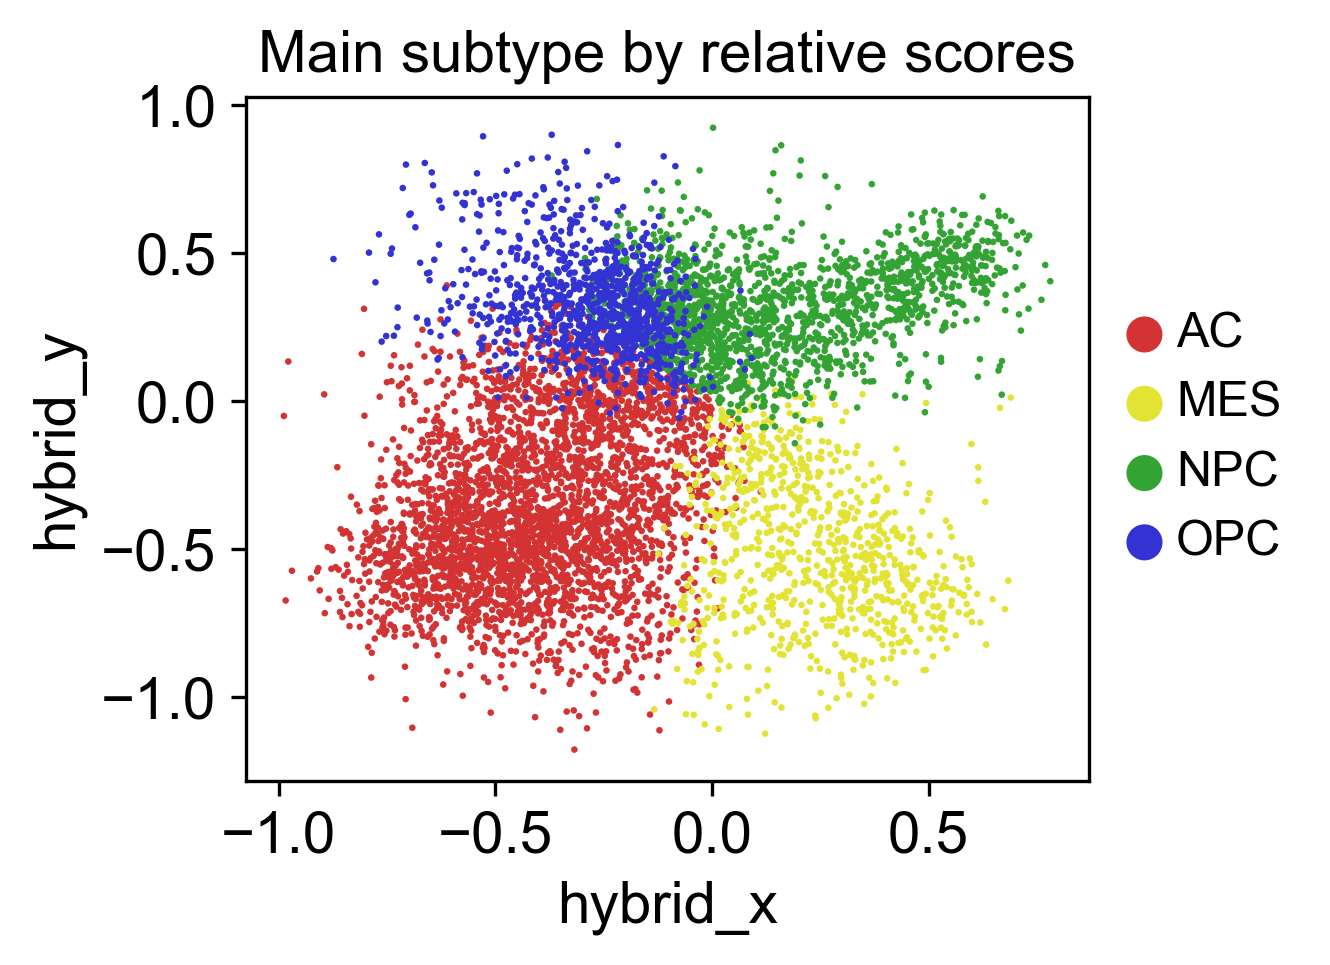

In [19]:
mes = np.maximum(adata.obs["MES2"],adata.obs["MES1"])
npc = np.maximum(adata.obs["NPC1MM"],adata.obs["NPC2MM"])
ac = adata.obs["AC"]
opc = adata.obs["OPC"]

npc_opc = np.log2(abs(npc-opc)+1)*(npc-opc)/abs(npc-opc)
npc_mes = np.log2(abs(npc-mes)+1)*(npc-mes)/abs(npc-mes)
opc_ac = np.log2(abs(opc-ac)+1)*(opc-ac)/abs(opc-ac)
mes_ac = np.log2(abs(mes-ac)+1)*(mes-ac)/abs(mes-ac)

# then, we can combine npc_opc and mes_ac to get the x-axis, and likewise for y-axis

xaxis = npc_opc + mes_ac
yaxis = opc_ac + npc_mes

adata.obs["hybrid_x"] = xaxis
adata.obs["hybrid_y"] = yaxis
sc.set_figure_params(dpi=150, figsize=(4, 3))

sc.pl.scatter(
    adata, 
    x="hybrid_x", 
    y="hybrid_y",
    color="combined_subtype",
    palette=combined_palette,
    title="Combined subtype by relative scores",
    size=10,
    show=False,
    legend_fontsize="small",
)
plt.grid(False)
plt.show()

sc.pl.scatter(
    adata, 
    x="hybrid_x", 
    y="hybrid_y",
    color="main_subtype",
    palette=main_palette,
    title="Main subtype by relative scores",
    size=10,
    show=False,
    legend_fontsize="small",
)
plt.grid(False)
plt.show()

In [20]:
# write dataset for future use
adata.write("neftel_smartseq2_malignant_hybrids.h5ad")